# Monica Barros #
# Trabalho final de BI #
## Data de entrega: 08/02/2020 ##

## Crie wordclouds para empresa, estado e serviço com intuito de saber qual é a empresa com mais reclamações.

## Para as reclamações retire os dados null, faça uma tokenização e logo um stopwords crie depois uma wordcloud. 


In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os
#workdir_path = '/content/drive/My Drive/BIMaster_2019/trabalho_leonardo/' 
workdir_path = '/home/jovyan/work/BIMaster_2019/BIMaster_2019_Computacao Paralela'
os.chdir(workdir_path)


## Inicialização #


In [3]:
#!pip install nltk
import nltk

In [4]:
#!pip install wordcloud
import wordcloud

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
plt.style.use('fivethirtyeight')

import seaborn as sns; 
sns.set(rc={'figure.figsize':(17,6)})

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

import re
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


# Exibe versões de principais módulos
print('Versão Pandas :', pd.__version__)
print('')
print('Versão Numpy :', np.__version__)
print('')
print('Versão Seaborn :', sns.__version__)
print('')
print('Versão Wordcloud :', wordcloud.__version__)

Versão Pandas : 0.25.1

Versão Numpy : 1.17.2

Versão Seaborn : 0.9.0

Versão Wordcloud : 1.6.0


## Leitura dos Dados ##

In [6]:
df = pd.read_csv('base reclamações.csv', sep = ';', encoding = 'latin1')

In [7]:
# Renomeando a última coluna
df.columns = ['Regiao ','estado','empresa','subsidiaria  ','area ','serviço','problema','faixa etaria']

In [8]:
df.shape

(42307, 8)

Existem 42307 linhas na base de reclamações.

In [9]:
# Número de missings/vNaNs em cada coluna
df.isnull().sum()

Regiao              0
estado              0
empresa             1
subsidiaria      6530
area             5329
serviço             0
problema         8936
faixa etaria        0
dtype: int64

## Análise por empresa e Estado

In [10]:
# Cria uma cópia do dataframe original com apenas 4 colunas, verifica o número de NaNs e elimina-os se necessário
df2 = df.copy()  
df2 = df2[['estado', 'empresa', 'serviço', 'problema']]
df2.head()

,estado,empresa,serviço,problema
0,SP,ITAÚ UNIBANCO S/A,Outros Contratos,"Contrato (não cumprimento, alteração, transfer..."
1,SP,CLARO S/A,Telefonia Fixa ( Plano de Expansão / Compra e ...,Contrato - Rescisão/alteração unilateral
2,SP,ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,Energia Elétrica,PID - Pedido de Indenização por Danos Morais
3,SP,GNN GARAGENS LTDA - EPP,"Estacionamento ( Particular, Supermercado, Sho...","Vicio de qualidade (mal executado, inadequado,..."
4,SP,CLARO S/A,Telefonia Fixa ( Plano de Expansão / Compra e ...,"Vicio de qualidade (mal executado, inadequado,..."


**Na célula a seguir verificamos que não existem valores faltantes no Dataframe que contém apenas as colunas 'estado', 'empresa', 'servico' e 'problema'.**

In [11]:
df2 = df2.dropna()
df2.isna().sum()

estado      0
empresa     0
serviço     0
problema    0
dtype: int64

In [12]:
# Força a conversão das colunas para string
df2['empresa'] = df2.empresa.apply(str)
df2['estado'] = df2.estado.apply(str)
df2['serviço'] = df2.serviço.apply(str)
df2['problema'] = df2.problema.apply(str)

In [13]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33371 entries, 0 to 42306
Data columns (total 4 columns):
estado      33371 non-null object
empresa     33371 non-null object
serviço     33371 non-null object
problema    33371 non-null object
dtypes: object(4)
memory usage: 1.3+ MB


### Quais são as 5 empresas mais frequentes?

In [14]:
df2.empresa.value_counts(normalize=True).to_frame().head()

,empresa
TELEFONICA BRASIL S/A,0.024362
CLARO S/A,0.019118
ELETROPAULO METROPOLITANA ELETRICIDADE DE S PAULO,0.014384
TIM CELULAR S/A,0.012256
VIA VAREJO S/A,0.009619


### Quais são os 5 serviços mais frequentes?

In [15]:
df2.serviço.value_counts(normalize=True).to_frame().head()

,serviço
"Telefone ( Convencional, Celular, Interfone, Etc. )",0.120943
Telefonia Celular,0.075305
Telefonia Fixa ( Plano de Expansão / Compra e Venda / Locação ),0.070750
Banco comercial,0.054568
Cartão de Crédito,0.053999


### Quais são os 5 Estados mais frequentes?

In [16]:
df2.estado.value_counts(normalize=True).to_frame().head()

,estado
SP,0.223907
MS,0.141260
GO,0.122172
MT,0.096461
RN,0.078541


### Quais são os 5 problemas mais frequentes?

In [17]:
df2.problema.value_counts(normalize=True).to_frame().head()

,problema
Produto com vício,0.181085
Cobrança indevida/abusiva,0.140691
Cobrança indevida.,0.098049
"Peso, volume e quantidade",0.051722
"Garantia (Abrangência, cobertura, etc.)",0.043091


## Etapas de pré-processamento de texto - remova números, letras maiúsculas e pontuação

In [18]:
import string

alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", ' ', x)

# Substitui s/a por '', epp por '', ltda por ''
punc_re = lambda x: re.sub(r"s/a|epp|ltda", ' ' , x.lower())

# Converte para minúscula
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove espaços extras
punc_remove_extra_spaces = lambda x: str.rstrip(x)

In [19]:
df3 = df2.copy()

In [20]:
import string

# Processa o texto da coluna 'empresa'
df3['empresa'] = df3.empresa.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)
# Processa o texto da coluna 'servico'
df3['serviço'] = df3.serviço.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)
# Processa o texto da coluna 'problema'
df3['problema'] = df3.problema.map(punc_re).map(alphanumeric).map(punc_lower).map(punc_remove_extra_spaces)

df3.head()

,estado,empresa,serviço,problema
0,SP,itaú unibanco,outros contratos,contrato não cumprimento alteração transfer...
1,SP,claro,telefonia fixa plano de expansão compra e ...,contrato rescisão alteração unilateral
2,SP,eletropaulo metropolitana eletricidade de s paulo,energia elétrica,pid pedido de indenização por danos morais
3,SP,gnn garagens,estacionamento particular supermercado sho...,vicio de qualidade mal executado inadequado ...
4,SP,claro,telefonia fixa plano de expansão compra e ...,vicio de qualidade mal executado inadequado ...


In [21]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Cria lista de stopwords em português

In [22]:
stopWords_list = list(stopwords.words('portuguese'))
len(stopWords_list)
stopWords_list.sort()
stopWords_list[0:10]

['a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'até']

## Wordcloud para empresas

In [23]:
# Defina lista de palavras a serem eliminadas
CLEANING_LST = ['ltda','s/a','/', 'de', 'do', 'kd','s', 'a', 'me', 'com', 'etc'] + stopWords_list
CLEANING_LST.sort()
print(len(CLEANING_LST))

215


In [24]:
# Cria bloco de texto a partir da informação das empresas
text_empresa = " ".join(linha for linha in df3.empresa)
print ("Existem {} palavras na combinação de todas as reclamações.".format(len(text_empresa)))

#token_text_empresa = nltk.word_tokenize(text_empresa, language='portuguese')
#print("Tokenização Completada!")

Existem 890097 palavras na combinação de todas as reclamações.


In [25]:
print(type(text_empresa))
print(len(text_empresa))
print(text_empresa[0:30])

<class 'str'>
890097
itaú unibanco claro eletropaul


In [26]:
#print(type(token_text_empresa))
#print(len(token_text_empresa))
#print(token_text_empresa[0:5])

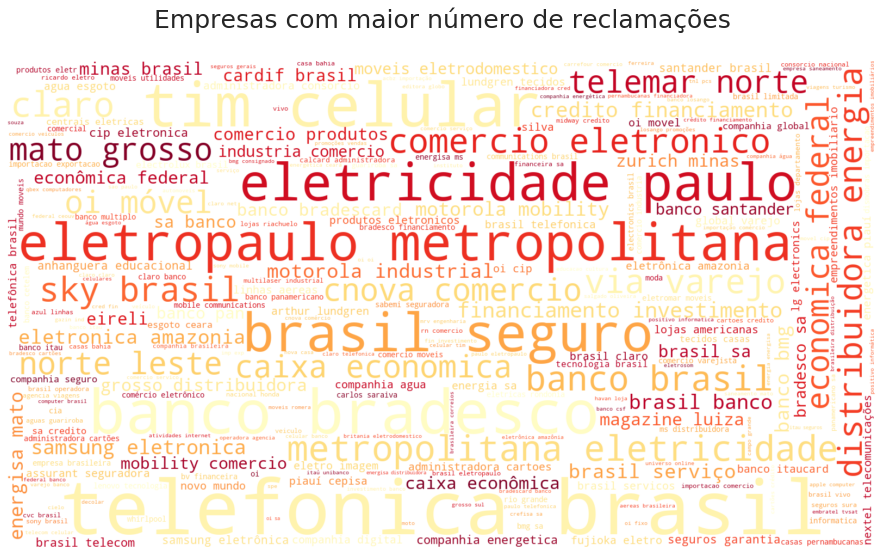

In [27]:
linha = None
wordcloud_empresa = WordCloud(stopwords=CLEANING_LST, background_color="white", 
                      colormap = 'YlOrRd', max_words = 250, width=1600, 
                      height=900, random_state=42).generate(text_empresa)

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud_empresa, interpolation='bilinear') 
plt.title('Empresas com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

## Wordcloud para Estados

In [28]:
df3.estado.value_counts().sort_values(ascending = False).head()

SP    7472
MS    4714
GO    4077
MT    3219
RN    2621
Name: estado, dtype: int64

Existem 133482 palavras na combinação de todas as reclamações por Estado.


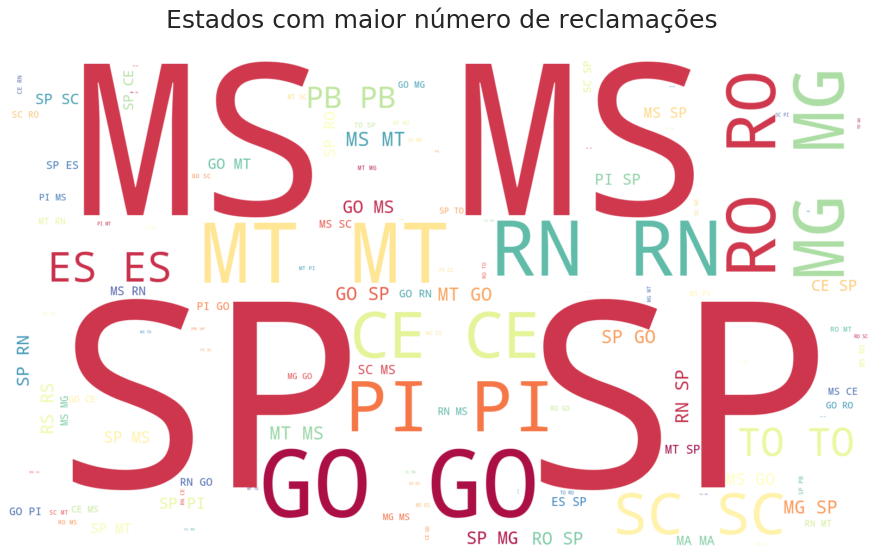

In [29]:
# Cria bloco de texto a partir da informação dos Estados
linha = None
text_UF = "++".join(linha for linha in df3.estado)
print ("Existem {} palavras na combinação de todas as reclamações por Estado.".format(len(text_UF)))

wordcloud_UF = WordCloud(stopwords=CLEANING_LST, background_color="white", 
                      colormap = 'Spectral', width=1600, 
                      height=900, random_state=42).generate(text_UF) #, max_words = 250, 

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud_UF, interpolation='bilinear') 
plt.title('Estados com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

In [30]:
def recode_UF(estado):
    ''' função para converter código da UF em nome'''
    nome = 'não encontrado'
    if estado == 'AC':
        nome = 'Acre'
    if estado == 'AL':
        nome = 'Alagoas'
    if estado == 'AM':
        nome = 'Amazonas'
    if estado == 'AP':
        nome = 'Amapá'
    if estado == 'BA':
        nome = 'Bahia'
    if estado == 'CE':
        nome = 'Ceará'
    if estado == 'DF':
        nome = 'Distrito_Federal'
    if estado == 'ES':
        nome = 'Espírito_Santo'
    if estado == 'GO':
        nome = 'Goiás'
    if estado == 'MA':
        nome = 'Maranhão'
    if estado == 'MG':
        nome = 'Minas_Gerais'
    if estado == 'MS':
        nome = 'Mato_Grosso_do_Sul'
    if estado == 'MT':
        nome = 'Mato_Grosso'
    if estado == 'PA':
        nome = 'Pará'
    if estado == 'PB':
        nome = 'Paraíba'
    if estado == 'PE':
        nome = 'Pernambuco'
    if estado == 'PI':
        nome = 'Piauí'
    if estado == 'PR':
        nome = 'Paraná'
    if estado == 'RJ':
        nome = 'Rio_de_Janeiro'
    if estado == 'RN':
        nome = 'Rio_Grande_do_Norte'
    if estado == 'RO':
        nome = 'Rondônia'
    if estado == 'RR':
        nome = 'Roraima'
    if estado == 'RS':
        nome = 'Rio_Grande_do_Sul'
    if estado == 'SC':
        nome = 'Santa_Catarina'
    if estado == 'SE':
        nome = 'Sergipe'
    if estado == 'SP':
        nome = 'São_Paulo'
    if estado == 'TO':
        nome = 'Tocantins'
    return nome

In [31]:
UF_recoded = [recode_UF(item) for item in df3.estado]

UF_recoded_string = " ".join(linha for linha in UF_recoded);

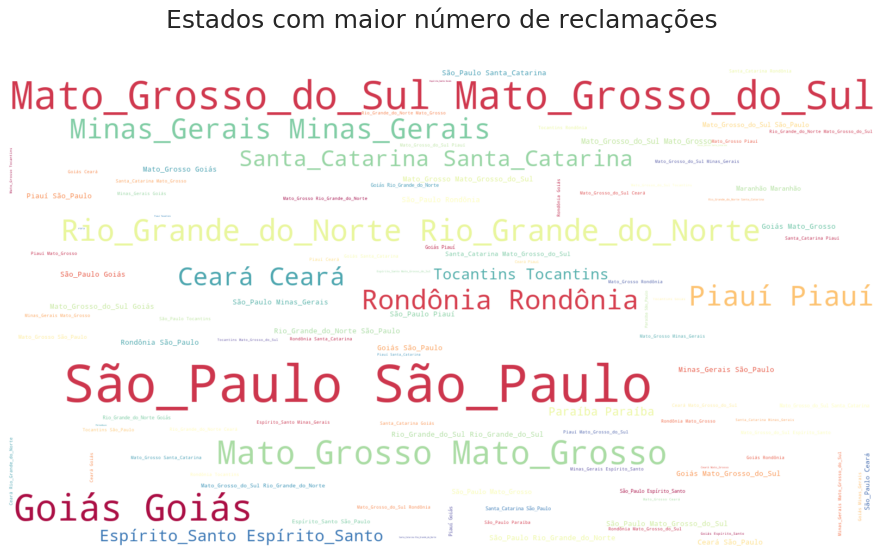

In [32]:
wordcloud_UF2 = WordCloud(background_color="white", stopwords=CLEANING_LST, 
                      colormap = 'Spectral', width=1600, height=900, random_state=42).generate(UF_recoded_string)

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud_UF2, interpolation='bilinear') 
plt.title('Estados com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

## Wordcloud para serviços

Existem 1164347 palavras na combinação de todos os serviços.


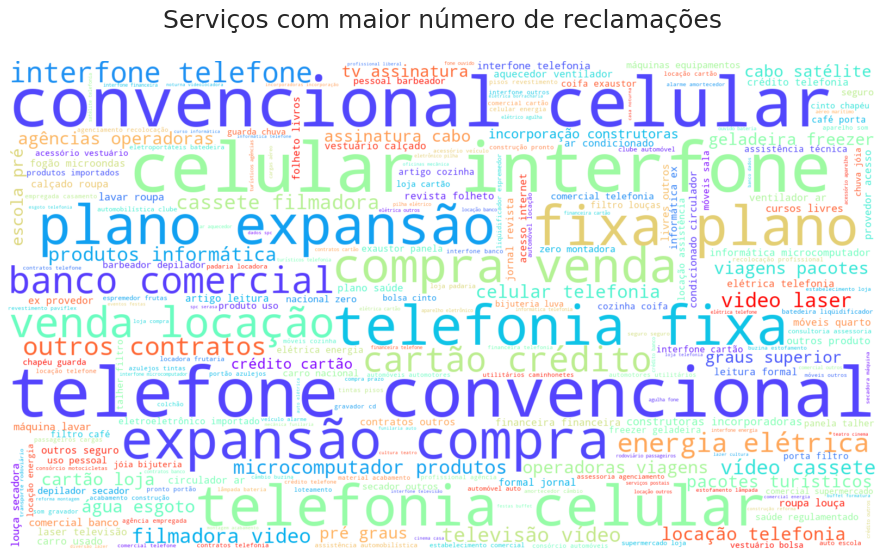

In [33]:
# Cria bloco de texto a partir da informação dos serviços
linha = None

text_serviço = " ".join(linha for linha in df3.serviço)
print ("Existem {} palavras na combinação de todos os serviços.".format(len(text_serviço)))

wordcloud_serviço = WordCloud(stopwords=CLEANING_LST, background_color="white", 
                      colormap = 'rainbow', max_words = 250, width=1600, 
                      height=900, random_state=42).generate(text_serviço)

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud_serviço, interpolation='bilinear') 
plt.title('Serviços com maior número de reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

In [34]:
text_problema

NameError: name 'text_problema' is not defined

## Wordcloud para as Reclamações

In [ ]:
# Cria bloco de texto a partir da informação das reclamações e tokeniza
text_problema = " ".join(linha for linha in df3.problema)
print ("Existem {} palavras na combinação de todas as reclamações.".format(len(text_problema)))

token_text_problema = nltk.word_tokenize(text_problema, language='portuguese')
print("Tokenização Completada!")

### Cria wordcloud a partir da lista de reclamações tokenizada

In [ ]:
comment_words = ' '

for val in token_text_problema:
    val = str(val) # converte para string
    tokens = val.split() # particiona os valores 
    for i in range(len(tokens)): 
        for words in tokens: 
            comment_words = comment_words + words + ' '
    
wordcloud_problema = WordCloud(width=1600, height=900, random_state=42,
                background_color ='white', colormap = 'nipy_spectral',
                stopwords = CLEANING_LST, min_font_size = 20).generate(comment_words) 

plt.figure(figsize = (16,9)) 
plt.imshow(wordcloud_problema, interpolation='bilinear') 
plt.title('Principais reclamações\n', fontsize = 25)
plt.axis("off") 
plt.show()

## Salva Wordclouds em arquivos

In [ ]:
wordcloud_empresa.to_file('cloud_empresa.png')
wordcloud_UF.to_file('cloud_UF.png')
wordcloud_UF2.to_file('cloud_UF2.png')
wordcloud_serviço.to_file('cloud_serviço.png')
wordcloud_problema.to_file('cloud_reclamacao.png')